<a href="https://colab.research.google.com/github/lalearp/covid19-genome-analysis/blob/main/Cancer_gene_expression_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Cancer Gene Expression Analysis**

This project used the GSE13507 (bladder cancer) dataset to compare gene expression between normal and cancer tissues. Due to its small and imbalanced nature, results may be limited. A larger, balanced dataset like TCGA or GSE25066 could improve classification accuracy and reduce bias.

Classification Report After SMOTE:
              precision    recall  f1-score   support

           0       0.96      1.00      0.98        74
           1       1.00      0.96      0.98        68

    accuracy                           0.98       142
   macro avg       0.98      0.98      0.98       142
weighted avg       0.98      0.98      0.98       142



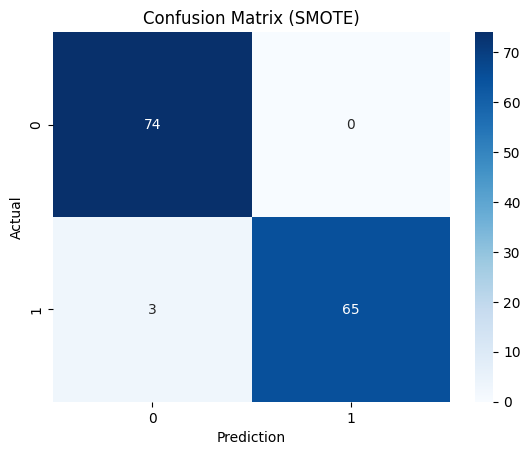

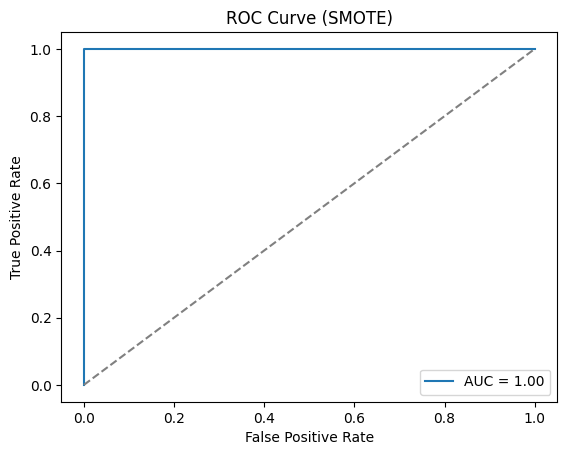


 retraining classifier with differentially expressed genes...
Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         7
           1       0.91      1.00      0.95        70

    accuracy                           0.91        77
   macro avg       0.45      0.50      0.48        77
weighted avg       0.83      0.91      0.87        77

📊 Retrained classifier using 13612 differentially expressed genes


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/m

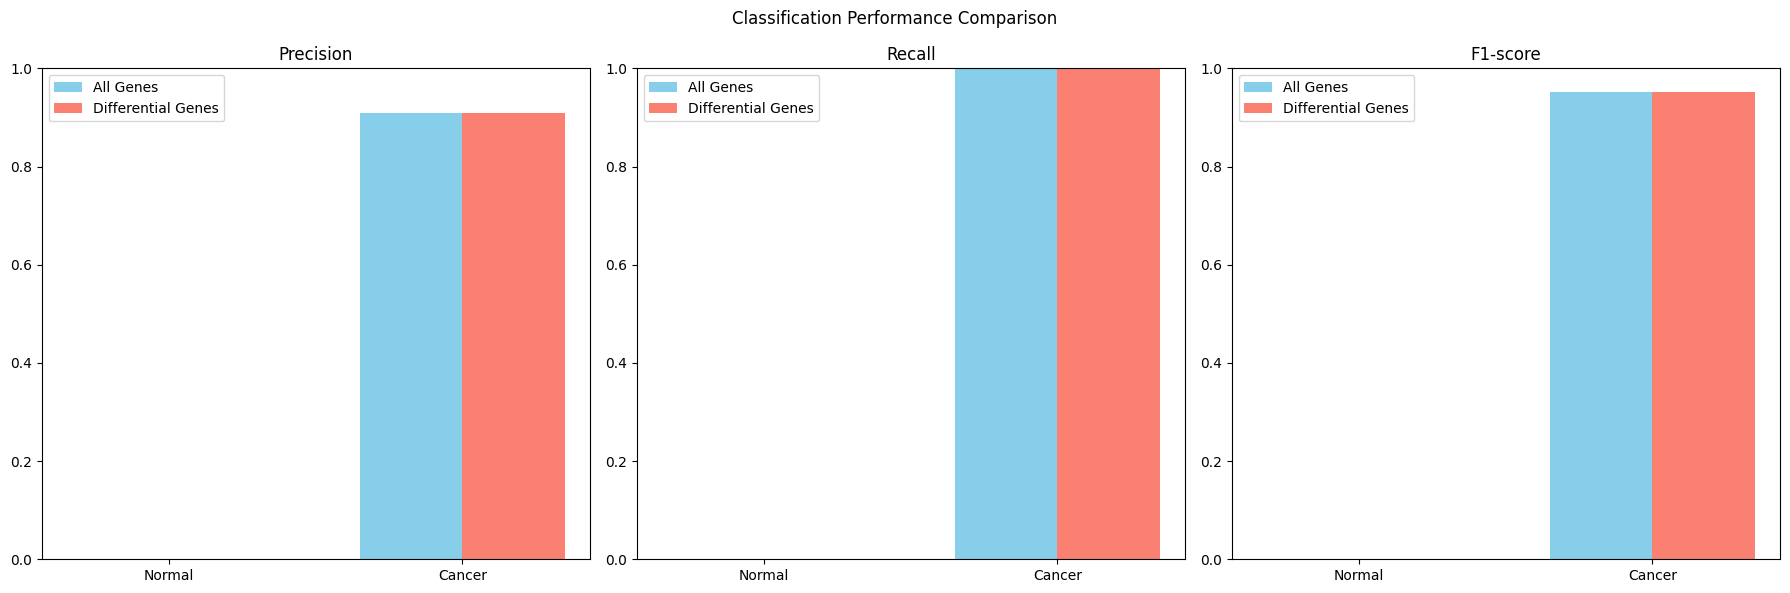

🎗️ Starting Cancer Biomarker Analysis...


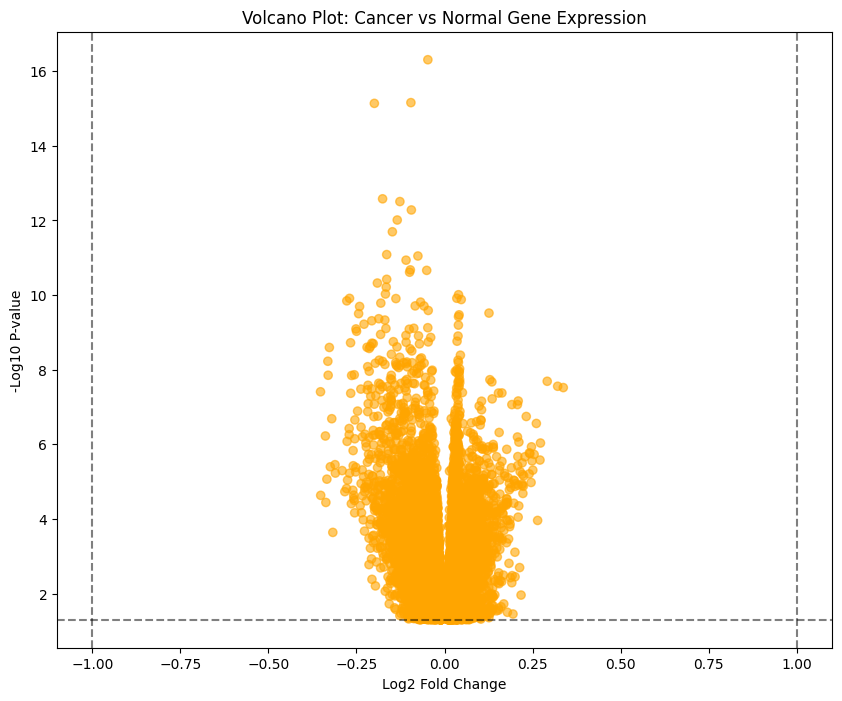

Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         7
           1       0.91      1.00      0.95        70

    accuracy                           0.91        77
   macro avg       0.45      0.50      0.48        77
weighted avg       0.83      0.91      0.87        77

Found 13612 differentially expressed genes


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from scipy import stats
from imblearn.over_sampling import SMOTE
import requests
import io
import os
import gzip
!pip install imbalanced-learn

def load_cancer_data():
    file_path = "/content/GSE13507_series_matrix.txt.gz"

    if not os.path.exists(file_path):
        url = "https://ftp.ncbi.nlm.nih.gov/geo/series/GSE13nnn/GSE13507/matrix/GSE13507_series_matrix.txt.gz"
        print(f"Downloading data from {url}...")
        response = requests.get(url)
        response.raise_for_status()
        with open(file_path, 'wb') as f:
            f.write(response.content)
        print("Download complete.")

    df = pd.read_csv(file_path, sep="\t", comment="!", skiprows=0, compression='gzip')
    df = df.set_index(df.columns[0])
    df = df.transpose()
    df["diagnosis"] = [0]*20 + [1]*(df.shape[0]-20)  # 0=normal 1=cancer

    return df

def find_differentially_expressed_genes(df, p_value_threshold=0.05):
    gene_columns = [col for col in df.columns if col != 'diagnosis']
    de_genes = []

    for gene in gene_columns:
        normal_expr = df[df['diagnosis'] == 0][gene]
        cancer_expr = df[df['diagnosis'] == 1][gene]

        t_stat, p_value = stats.ttest_ind(normal_expr, cancer_expr, nan_policy='omit')
        if p_value < p_value_threshold:
            fold_change = cancer_expr.mean() / normal_expr.mean()
            de_genes.append({
                'gene': gene,
                'p_value': p_value,
                'fold_change': fold_change,
                't_statistic': t_stat,
                'normal_mean': normal_expr.mean(),
                'cancer_mean': cancer_expr.mean()
            })

    return pd.DataFrame(de_genes)

def create_volcano_plot(de_results):
    plt.figure(figsize=(10, 8))

    # -log10(p_value)
    neg_log_p = -np.log10(de_results['p_value'])
    log2_fc = np.log2(de_results['fold_change'])


    colors = []
    for i, row in de_results.iterrows():
        if row['p_value'] < 0.05 and abs(np.log2(row['fold_change'])) > 1:
            colors.append('red')
        elif row['p_value'] < 0.05:
            colors.append('orange')
        else:
            colors.append('gray')

    plt.scatter(log2_fc, neg_log_p, c=colors, alpha=0.6)
    plt.xlabel('Log2 Fold Change')
    plt.ylabel('-Log10 P-value')
    plt.title('Volcano Plot: Cancer vs Normal Gene Expression')
    plt.axhline(-np.log10(0.05), color='black', linestyle='--', alpha=0.5)
    plt.axvline(1, color='black', linestyle='--', alpha=0.5)
    plt.axvline(-1, color='black', linestyle='--', alpha=0.5)

    plt.show()

def build_cancer_classifier(df):

    gene_columns = [col for col in df.columns if col != 'diagnosis']
    X = df[gene_columns]
    y = df['diagnosis']


    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


    rf = RandomForestClassifier(n_estimators=100, random_state=42)
    rf.fit(X_train, y_train)


    y_pred = rf.predict(X_test)


    print("Classification Report:")
    print(classification_report(y_test, y_pred))


    feature_importance = pd.DataFrame({
        'gene': gene_columns,
        'importance': rf.feature_importances_
    }).sort_values('importance', ascending=False)

    return rf, feature_importance


data = load_cancer_data()
de_results = find_differentially_expressed_genes(data)


de_genes_list = de_results['gene'].tolist()


filtered_data = data[de_genes_list + ['diagnosis']]


X = filtered_data.drop(columns='diagnosis')
y = filtered_data['diagnosis']

smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)


X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.3, random_state=42)
rf_smote = RandomForestClassifier(n_estimators=100, random_state=42)
rf_smote.fit(X_train, y_train)
y_pred_smote = rf_smote.predict(X_test)


print("Classification Report After SMOTE:")
print(classification_report(y_test, y_pred_smote, zero_division=0))


from sklearn.metrics import confusion_matrix, roc_curve, auc


cm = confusion_matrix(y_test, y_pred_smote)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix (SMOTE)")
plt.xlabel("Prediction")
plt.ylabel("Actual")

plt.show()


y_prob = rf_smote.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.title("ROC Curve (SMOTE)")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()


print("\n retraining classifier with differentially expressed genes...")
classifier_de, importance_de = build_cancer_classifier(filtered_data)
print(f"📊 Retrained classifier using {len(de_genes_list)} differentially expressed genes")

def compare_classification_reports(y_true, y_pred_all, y_pred_de):
    from sklearn.metrics import classification_report
    import matplotlib.pyplot as plt


    report_all = classification_report(y_true, y_pred_all, output_dict=True)
    report_de = classification_report(y_true, y_pred_de, output_dict=True)

    labels = ['precision', 'recall', 'f1-score']
    classes = ['0', '1']

    x = np.arange(len(classes))
    width = 0.35

    fig, axs = plt.subplots(1, 3, figsize=(18, 6))
    for i, metric in enumerate(labels):
        values_all = [report_all[c][metric] for c in classes]
        values_de = [report_de[c][metric] for c in classes]

        axs[i].bar(x - width/2, values_all, width, label='All Genes', color='skyblue')
        axs[i].bar(x + width/2, values_de, width, label='Differential Genes', color='salmon')
        axs[i].set_title(metric.capitalize())
        axs[i].set_xticks(x)
        axs[i].set_xticklabels(['Normal', 'Cancer'])
        axs[i].legend()
        axs[i].set_ylim(0, 1)

    plt.suptitle('Classification Performance Comparison')
    plt.tight_layout()
    plt.show()

_, X_test_all, _, y_test = train_test_split(data.drop(columns='diagnosis'), data['diagnosis'], test_size=0.3, random_state=42)
y_pred_all = classifier.predict(X_test_all)


_, X_test_de, _, _ = train_test_split(filtered_data.drop(columns='diagnosis'), filtered_data['diagnosis'], test_size=0.3, random_state=42)
y_pred_de = classifier_de.predict(X_test_de)


compare_classification_reports(y_test, y_pred_all, y_pred_de)


def run_analysis():
    print("🎗️ Starting Cancer Biomarker Analysis...")
    create_volcano_plot(de_results)
    classifier, importance = build_cancer_classifier(data)
    print(f"Found {len(de_results)} differentially expressed genes")

run_analysis()

